In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import statistics
import seaborn as sns
from modules.stats import *
from modules.PCA import *
from modules.LDA import *
from modules.read_data import *
from modules.LR import *
from modules.KNN import *
from modules.DTW import *
from modules.ROC import *

In [4]:
%store -r TPR1
%store -r FPR1

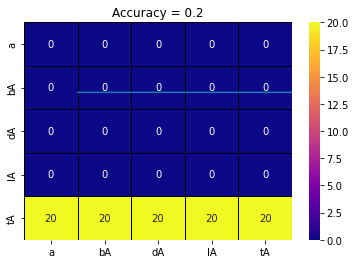

In [6]:
#LR
path = 'Assets/Handwriting Dataset'
# Given Datasets
data_class = ['a', 'bA', 'dA', 'lA', 'tA']

B = []
C = [] #train
D = [] #dev
# Read Data
for i in data_class:
	C.append(read_handwritting(path, i, 'train')[1])
	D.append(read_handwritting(path, i, 'dev')[1])
	B.append(read_handwritting(path, i, 'dev')[0])
C_y = []
D_y = []

for i in range(5):
	C_y.append(i * np.ones(len(C[i])))
	D_y.append(i * np.ones(len(D[i])))
X =  np.concatenate(C, axis=0)
X_d = np.concatenate(D, axis=0)
Y = np.concatenate(C_y, axis=0)
Y_d = np.concatenate(D_y, axis=0)
pca = False
lda = True
lda = ~pca & lda #if pca is true then lda is false
if pca:
	pc = 1
	μ, Σ = stats(X)
	eigval, Q = PCA(Σ, pc)
	X = X @ Q
	X_d = X_d @ Q
if lda:
	pc = 1
	μ, Σ = stats(X)
	μk = []
	for c in range(5):
		μk.append(stats(X[Y == c])[0])
	μk = np.array(μk)
	v = LDA(X,Y,μ,μk,pc)
	X = np.abs(X @ v)
	X_d = np.abs(X_d @ v)
if pca or lda:	
	C_new = []
	D_new = []
	nc=0
	nd=0
	for i in range(5):
		c = X[nc:nc+C[i].shape[0]]
		d = X_d[nd:nd+D[i].shape[0]]
		C_new.append(c)
		D_new.append(d)
		nc += C[i].shape[0]
		nd += D[i].shape[0]
	D = D_new
	C = C_new
train_data = C; total_train = X 
dev_data = D; total_dev = X_d
#training LR
loss_steps, w_ml = gradient_descent(train_data)

#error vs iter 
plt.plot(loss_steps['step'], loss_steps['error'])
plt.xlabel('step'); plt.ylabel('error')

#making prediction
p = softmax(- total_dev @ w_ml, axis=1)
t = np.argmax(p, axis=1)

P = []
for c in range(5):
	s = dev_data[c].shape[0]
	P.append(t[:s])
	t = np.delete(t, slice(s), 0)
# print(P[0])
y_pred = np.vstack((P[0].reshape(-1,1), P[1].reshape(-1,1), P[2].reshape(-1,1), P[3].reshape(-1,1), P[4].reshape(-1,1))).flatten()
Yn_d = []
for c in range(5):
	Yn_d.append(c * np.ones(len(B[c])))
Yn_d = np.array(Yn_d)

yn_pred = np.zeros_like(Yn_d)
n = 0
for c in range(5):
	for i in range(len(B[c])):
		data = y_pred[n:n+B[c][i].shape[0]]
		n += B[c][i].shape[0]
		yn_pred[c][i] = statistics.mode(data)
cm = confusion_matrix( yn_pred.flatten(), Yn_d.flatten(),)
accuracy = accuracy_score(Yn_d.flatten(),yn_pred.flatten())
ax = sns.heatmap(cm, annot = True, cmap ='plasma',linecolor ='black', linewidths = 1, fmt = '.0f', xticklabels = data_class, yticklabels = data_class)
ax.set_title(f'Accuracy = {accuracy}')
TPR3 = 0; FPR3 = 0
for c in range(5):
	tpr, fpr = ROC(label_binarize(Y_d, classes=[0,1,2,3,4])[:,c], p[:,c])
	TPR3 += tpr/5
	FPR3 += fpr/5

In [7]:
%store -r TPR2
%store -r FPR2

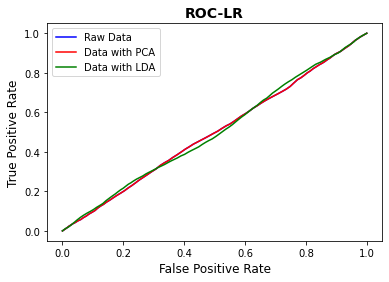

In [8]:
plt.plot(FPR1, TPR1, 'b')
plt.plot(FPR2, TPR2, 'r')
plt.plot(FPR3, TPR3, 'g')
# plt.plot(FPR4, TPR4)
plt.xlabel('False Positive Rate',fontsize=12); plt.ylabel('True Positive Rate',fontsize=12)
plt.title('ROC-LR',fontweight="bold", fontsize=14)
plt.legend(['Raw Data', 'Data with PCA', 'Data with LDA'])